In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import os


In [2]:
notebook_path = os.path.abspath("4. Cross Validation.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim\\Cluster_Data_All_Month\\*.csv"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string

In [4]:
csv_files = glob.glob(modified_path)

In [5]:
weekday_file_paths = [path for path in csv_files if 'weekday' in path]
weekend_file_paths = [path for path in csv_files if 'weekend' in path]

In [6]:
weekday_dict = {}

for index, file in enumerate(weekday_file_paths):
    current_df = pd.read_csv(file, index_col=[0])
    current_df['Date'] =  pd.to_datetime(current_df['Date'])
    current_df.index = pd.to_datetime(current_df.index)

    weekday_dict[int(weekday_file_paths[index][-13:-12])] = current_df

In [7]:
weekday_dict_april = {}

for label in weekday_dict:
    # Filter the data for the month of April (month number 4)
    april_data = weekday_dict[label][weekday_dict[label]['Date'].dt.month == 4]
    # Assign the filtered data to the corresponding label in the new dictionary
    weekday_dict_april[label] = april_data


In [8]:
weekend_dict = {}  

for index, file in enumerate(weekend_file_paths):
    current_df = pd.read_csv(file, index_col=[0])
    current_df['Date'] = pd.to_datetime(current_df['Date'])
    current_df.index = pd.to_datetime(current_df.index)

    weekend_dict[int(weekend_file_paths[index][-13:-12])] = current_df

In [9]:
endog_week_dict = {}

for label in weekday_dict:
    current_df = weekday_dict[label]
    current_df = current_df.reset_index()
    current_df = current_df.drop(columns=['index', 'Hour', 'Weekday', 'Date'])
    endog_week_dict[label] = current_df

In [10]:
endog_weekend_dict = {}

for label in weekend_dict:
    current_df = weekend_dict[label]
    current_df = current_df.reset_index()
    current_df = current_df.drop(columns=['index', 'Hour', 'Weekday', 'Date'])
    endog_weekend_dict[label] = current_df

In [11]:
for label in endog_week_dict:
    for diff in range(1,25,1):
        endog_week_dict[label][f"Count{-diff}"] = endog_week_dict[label].Count.diff(diff)
    endog_week_dict[label].dropna(inplace=True)        


In [17]:
notebook_path = os.path.abspath("4. Cross Validation.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim\\"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "df_all_data_grouped.csv"

In [21]:
df = pd.read_csv(modified_path)

In [24]:
df_endog = df[['Count']]

In [25]:
for diff in range(1,25,1):
    df_endog[f"Count{-diff}"] = df_endog.Count.diff(diff)
df_endog.dropna(inplace=True)            
df_endog.reset_index(inplace=True)
df_endog.drop(columns='index', inplace=True)

C:\Users\Max_G\AppData\Local\Temp\ipykernel_17028\3334669183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_endog[f"Count{-diff}"] = df_endog.Count.diff(diff)
C:\Users\Max_G\AppData\Local\Temp\ipykernel_17028\3334669183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_endog[f"Count{-diff}"] = df_endog.Count.diff(diff)
C:\Users\Max_G\AppData\Local\Temp\ipykernel_17028\3334669183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

# Gridsearch for all Week Data

# Searching for South Manhattan for 48 hours for best parameters

In [26]:
train_data = endog_week_dict[0][:-48]
test_data = endog_week_dict[0][-48:]


X_train = train_data.drop(['Count'], axis=1)
y_train = train_data['Count']

X_test = test_data.drop(['Count'], axis=1)
y_test = test_data['Count']

In [57]:



# Define the parameter grid for the grid search
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Different options for max_features
    'max_depth': [5, 10, 20, 30, 35, 40, 45],  # Different options for max_depth
    'min_samples_leaf': [1, 2, 4, 8, 10, 20]  # Different options for min_samples_leaf
}

tscv = TimeSeriesSplit(n_splits=5, test_size=48)

# Create a Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Define a custom scoring function based on RMSE
def rmse_scorer(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # We use a negative sign because GridSearchCV tries to maximize the score


# Create a GridSearchCV object with RMSE as the scoring metric
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=tscv, scoring=make_scorer(rmse_scorer), verbose=2)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best Parameters:")
print(grid_search.best_params_)

# Print the best cross-validated accuracy score
print("Best Cross-Validated Accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Set Root: {:.2f}".format(rmse))


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

In [30]:
# Create the RandomForestRegressor with specified hyperparameters
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # You may specify other hyperparameters as needed
    max_features=11,
    max_depth=30,
    min_samples_leaf=1,
    random_state=42,  # Set a random seed for reproducibility
    n_jobs=-1  # Use all available CPU cores for parallel processing
)


rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)


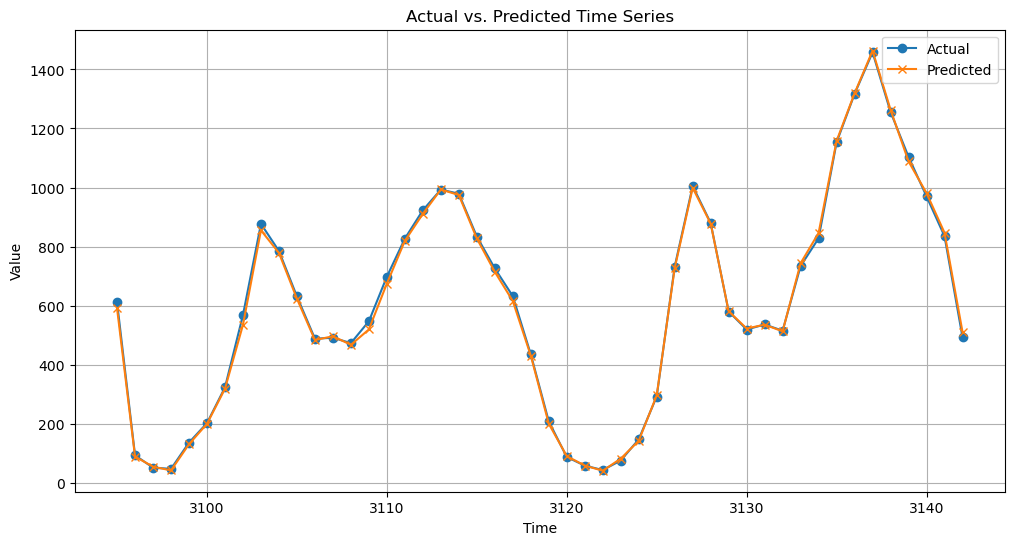

In [31]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', marker='o')
plt.plot(test_data.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs. Predicted Time Series')
plt.grid(True)
plt.show()

# Searching for all Data for 48 hours

In [32]:
train_data = df_endog[:-48]
test_data = df_endog[-48:]


X_train = train_data.drop(['Count'], axis=1)
y_train = train_data['Count']

X_test = test_data.drop(['Count'], axis=1)
y_test = test_data['Count']

In [53]:



# Define the parameter grid for the grid search
param_grid = {
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  # Different options for max_features
    'max_depth': [5, 10, 20, 30, 35, 40, 45],  # Different options for max_depth
    'min_samples_leaf': [1, 2, 4, 8, 10, 20]  # Different options for min_samples_leaf
}

tscv = TimeSeriesSplit(n_splits=5, test_size=48)

# Create a Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Define a custom scoring function based on RMSE
def rmse_scorer(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return -rmse  # We use a negative sign because GridSearchCV tries to maximize the score


# Create a GridSearchCV object with RMSE as the scoring metric
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=tscv, scoring=make_scorer(rmse_scorer), verbose=2)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best Parameters:")
print(grid_search.best_params_)

# Print the best cross-validated accuracy score
print("Best Cross-Validated Accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Set Root: {:.2f}".format(rmse))


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.2s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.2s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.2s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.2s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.8s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.5s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

In [54]:
# Create the RandomForestRegressor with specified hyperparameters
rf_regressor = RandomForestRegressor(
    n_estimators=100,  # You may specify other hyperparameters as needed
    max_features=12,
    max_depth=30,
    min_samples_leaf=1,
    random_state=42,  # Set a random seed for reproducibility
    n_jobs=-1  # Use all available CPU cores for parallel processing
)


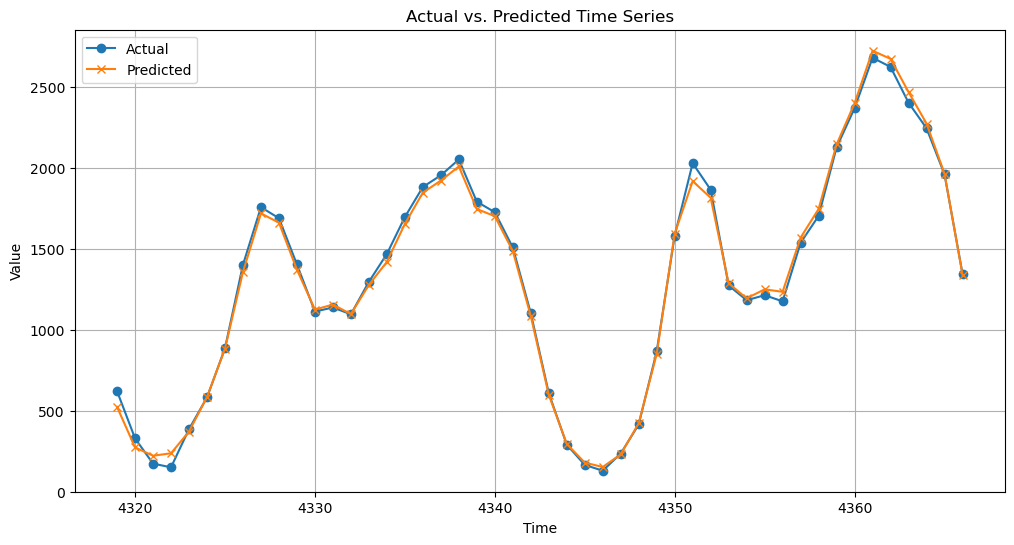

In [55]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', marker='o')
plt.plot(test_data.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs. Predicted Time Series')
plt.grid(True)
plt.show()

# Grid Search for the best parameter for all data

In [33]:
notebook_path = os.path.abspath("4. Cross Validation.ipynb")
notebook_directory = os.path.dirname(notebook_path)

replacement_string = "data\\interim\\Cluster_Data_All_Month\\"
index = notebook_directory.find("\\notebooks")
modified_path = notebook_directory[:index]

modified_path += "\\" + replacement_string + "df_all_counts_grouped.csv"

In [35]:
df_all_data = pd.read_csv(modified_path)

In [30]:
df_all_data.Date = pd.to_datetime(df_all_data['Date'])
df_all_data.drop(columns='Unnamed: 0', inplace=True)

In [68]:
# dropping all count columns, to add the specifically again in to dictionary with only each label
columns_to_drop = [col for col in df_all_data.columns if col.startswith('Count_')]

current_df_dict = {}

for label in range(0,6,1):
    # Drop all columns named 'count_'
    current_df = df_all_data.drop(columns=columns_to_drop)
    current_df[f'Count_{label}'] = df_all_data[f'Count_{label}']
    # Differencing the first 24 hours
    for diff in range(1,25,1):
        current_df[f'Count_{label}{-diff}'] = current_df[f'Count_{label}'].diff(diff)
    # differencing up to a week back
    for diff in range(48,169,24):
        current_df[f'Count_{label}{-diff}'] = current_df[f'Count_{label}'].diff(diff)
    current_df.dropna(inplace=True)   
    current_df.reset_index(inplace=True)  
    current_df.drop(columns=['Date', 'index'], inplace=True)             
    current_df_dict[label] = current_df

In [74]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Label', 'Best Parameters', 'Best RMSE'])

# Assuming you have a dictionary of DataFrames called current_df_dict
for label, current_df in current_df_dict.items():
    # Splitting the data into train and test
    train_data = current_df[:-48]
    test_data = current_df[-48:]

    X_train = train_data.drop([f'Count_{label}'], axis=1)
    y_train = train_data[f'Count_{label}']

    X_test = test_data.drop([f'Count_{label}'], axis=1)
    y_test = test_data[f'Count_{label}']

    # Define the parameter grid for the grid search
    param_grid = {
        'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'max_depth': [5, 10, 20, 30, 35, 40, 45],
        'min_samples_leaf': [1, 2, 4, 8, 10, 20]
    }

    tscv = TimeSeriesSplit(n_splits=5, test_size=48)

    # Create a Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # Define a custom scoring function based on RMSE
    def rmse_scorer(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return -rmse  # We use a negative sign because GridSearchCV tries to maximize the score

    # Create a GridSearchCV object with RMSE as the scoring metric
    grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=tscv, scoring=make_scorer(rmse_scorer), verbose=2)

    # Fit the grid search to your training data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and RMSE
    best_params = grid_search.best_params_
    best_rmse = grid_search.best_score_

    # Append the results to the results DataFrame
    results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)

# Print the results DataFrame
print(results_df)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   3.6s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.1s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=1; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=2; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=4; total time=   0.0s
[CV] END ....max_depth=5, max_features=1, min

C:\Users\Max_G\AppData\Local\Temp\ipykernel_3556\4226316426.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Label': label, 'Best Parameters': best_params, 'Best RMSE': best_rmse}, ignore_index=True)


In [102]:
results_df['Best Parameters'][5]

{'max_depth': 35, 'max_features': 15, 'min_samples_leaf': 2}